# Analisis Sentimen

Melakukan analisis sentimen pada data hasil crawling

## 1. Import Libraries

Import library yang akan digunakan

In [1]:
%pip install sastrawi
import os, re, json, string, pickle

import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from datetime import datetime
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

nltk.download('punkt')

Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\iFelz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 2. Load Dataset

Load data ke memmory menggunakan library pandas.

In [11]:
data1 = pd.read_csv('../data/Data Scraper - Indodax.csv')
# data2 = pd.read_csv('../data/Crawling Twitter Jakarta 25 - 23.csv')
# data3 = pd.read_csv('../data/Crawling Twitter Jakarta 22 - 19 setengah.csv')

**Menggabungkan data**

Menggabungkan 3 dataset tersebut menjadi satu

In [12]:
# Concate data
# data = pd.concat([data1,data2,data3])
# data.head()
data = pd.concat([data1])

In [13]:
# Cleanner 
def cleaning(text):
#     text = text[2:]
#     text = text.replace('\\n',' ')
    return text

In [14]:
data['Content'] =  data['Content'].apply(lambda x : cleaning(x))
data['Content'].values

array(['Pertama kali main disini dan pro disini lama" ngerasa ada yang aneh dan nga kuat akhir nya pindah ke platform B,Parahh aslilahh 1x,2x dan akhirnya berkali" kalau lagi harga tinggi pasti error, suka ngelist coin yang nga ada fungsinya yg ujung nya bakal di delist, Suka ngelist coin baru pas lagi tinggi"nya. Kasihan orang" awam yang baru gabung.',
       'YA ampun platform terbesar di indonesia masih bisa2nya kena tipu. Koin Vidy Vidyx aset masa depan di hold lama malah di delist trus uangnya dikemanain semuanya. Baru download tiba2 koin hilang semua. Astaga kecewa bgt. Dahlah bintang 1 cocok kok ini buat aplikasi.',
       'Indodax sehat???,..... 4hari terakhir ini gx bisa log in, selalu disuruhnya masukan pin,....? berkali2 donlot ulang aplikasi tetap saja sama. klo gx suport sama android 11. Mending didepak aja dari playstore.',
       ..., 'Lumayan mudah untuk withdrawnya..', 'Good', '👍'],
      dtype=object)

## 2. Data Preprocessing

Preprocess data text sebelum diolah

## 2.1. Stemmer

> Stemming merupakan suatu proses untuk menemukan kata dasar dari sebuah kata. Dengan menghilangkan semua imbuhan (affixes) baik yang terdiri dari awalan (prefixes), sisipan (infixes), akhiran (suffixes) dan confixes (kombinasi dari awalan dan akhiran) pada kata turunan. Stemming digunakan untuk mengganti bentuk dari suatu kata menjadi kata dasar dari kata tersebut yang sesuai dengan struktur morfologi Bahasa Indonesia yang baik dan benar.

Membuat Stemmer menggunakan sastrawi.

In [15]:
# Create Sastrawi stemmer
stemmer = StemmerFactory().create_stemmer()

## 2.2. Stopwords

> Stop words adalah kata umum (common words) yang biasanya muncul dalam jumlah besar dan dianggap tidak memiliki makna.

Akan dibuat list yang berisi stopword yang ada pada bahasa indonesia.

In [17]:
# Create Stopword
with open("../data/stopwords-id.txt", "r") as f:
    stop_words = f.readline()
    stop_words = stop_words.split()

## 2.3. Preprocessing function

Akan dilakukan beberapa tahap untuk preprocess data text agar siap digunakan, yaitu:

1. Normalisasi karakter string menjadi huruf kecil
2. Menghapus emoji
3. Menghapus setiap url
4. Menghapus tagging
5. Menghapus whitespace
6. Menghapus simbol '#' pada hashtag
7. Menghapus angka
8. Mengganti tanda baca menjadi '<spasi>'

In [18]:
# Preprocessor
def preprocessor(text):
    # Convert to lower case
    text = text.lower()
    # Remove additional code
    text = text.replace('\\xe2\\x80\\xa6', '')
    # Convert www.* or https?://* to URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',text)
    # Convert @username to AT_USER
    text = re.sub('@[^\s]+','',text)
    # Remove additional white spaces
    text = re.sub('[\s]+', ' ', text)
    # Replace #word with word
    text = re.sub(r'#([^\s]+)', r'\1',text)
    # Menghapus angka dari teks
    text = re.sub(r"\d+", "", text)
    # Menganti tanda baca dengan spasi
    text = text.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))
    return text

In [21]:
data['Content'] = data['Content'].apply(lambda x : preprocessor(x))
data['Content'].values

# Fungsi save hasil data yang sudah dibersihkan
data.to_csv('../output/cleaned_data.csv')

## 2.4. Tokenizer

Membuat custom tokenizer menggunakan `word_tokenize` dari library `nltk` lalu memfilter token tersebut.

In [20]:
# Tokenizer
def tokenizer(text):
    words = word_tokenize(text)
    tokens=[]
    for w in words:
        # add tokens
        if len(w) > 3 and w not in stop_words:
            w = stemmer.stem(w)
            tokens.append(w.lower())
    return " ".join(tokens)

In [22]:
# Untuk menghemat waktu running dilakukan loading tweet yang sudah
# dibersihkan sebelumnya
# with open('/content/Cleaned Data.txt') as reader:
#     data['Content'] = reader.read().split("\n")

with open('../output/cleaned_data.txt', 'rb') as f:
  contents = f.read()
# Uncomment dan run kode di bawah jika mengganti atau menambahkan
# metode preprocess data text, proses running membutuhkan waktu
# yang cukup lama (sekitar 1 jam)
# data['Content'] = data['Content'].apply(lambda x : tokenizer(x))

# data['Content'].values

## 2.5. Text Vectorization

Text vectorization adalah cara melakukan encode data text menjadi numerik. Berikut akan dilakukan vectorization menggunakan `TfidfVectorizer` dari library `scikit-learn`. Untuk mempelajari text vectorization lebih lanjut dapat membaca artikel [berikut](https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/)

In [23]:
# Defining Vectorizer object
vectorizer_tfidf = TfidfVectorizer(min_df=0.01, max_df=0.6)

# Load saved vectorizer
# vectorizer_tfidf = pickle.load(open('../model/vectorizer/vectorizer_tfidf.pickle', 'rb'))

**fit & transform**

Ubah data text menjadi encoded matrix

In [24]:
# fit and transform text data
word_tfidf = vectorizer_tfidf.fit_transform(data['Content'].values)

# Load saved transformed data
# word_tfidf = pickle.load(open('../model/vectorizer/word_tfidf.pickle', 'rb'))

Mengambil nama fitur / kata - kata yang terdapat dalam data dan melihat dimensi data setelah dilakukan vectorization menggunakan `TfidfVectorizer`

In [25]:
# Nama fitur
nama_fitur = vectorizer_tfidf.get_feature_names()

# Dimensi data
dimensions = word_tfidf.get_shape()
print(f"Jumlah artikel = {dimensions[0]}")
print(f"Jumlah fitur   = {dimensions[1]}")

Jumlah artikel = 1200
Jumlah fitur   = 308


## 2.6. Kata dengan bobot TF-IDF tertinggi

Melihat kata - kata dengan bobot TF-IDF tertinggi

In [26]:
content1, content2 = [], []

for n in range(dimensions[0]):
    # Convert sparse matrix row by row 
    row = word_tfidf.getrow(n).toarray()[0].ravel()
    # Get top values and its indexes 
    top_ten_indices = row.argsort()[-1]
    top_ten_values = row[row.argsort()[-1]]
    # Identify the highest TFIDF value and word #
    highestTFIDFword = nama_fitur[top_ten_indices]
    highestTFIDFvalue = top_ten_values
    top1word = {'nomor artikel': n+1, 'nilai TFIDF': highestTFIDFvalue,
                'top word': highestTFIDFword}
    content1.append(top1word)
    content2.append(highestTFIDFword)

# Hitung Frekuensi kata dengan bobot terbesar
content2 = np.asarray(content2)
words, n = np.unique(content2, return_counts=True)

# Convert to DataFrame lalu urutkan secara descending
# lalu pilih 20 kata dengan frekuensi terbesar 
words_data = pd.DataFrame({
    'Kata': words,
    'Banyak': n
}).sort_values(by='Banyak', ascending=False).head(20)
words_data 

,Kata,Banyak
275,yg,46
83,good,25
208,saya,18
261,untuk,14
145,mantap,13
165,nomor,13
168,ok,13
70,eror,12
34,bintang,11
97,jadi,11


**Visualisasi hasil**

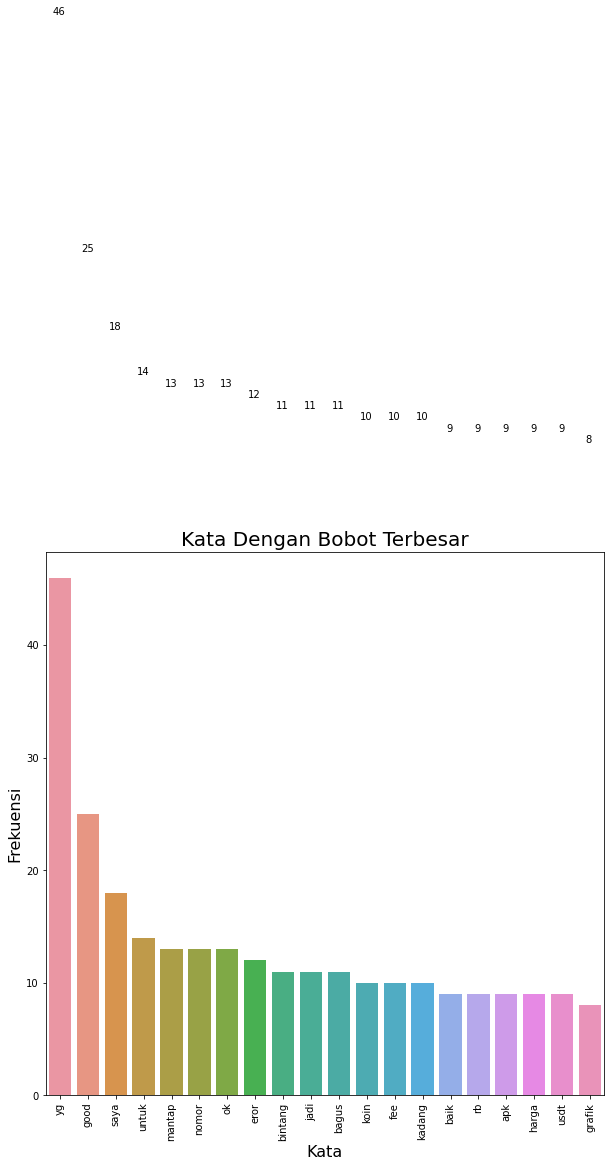

In [27]:
# Plotting Barplot
plt.figure(figsize = (10,10))
sns.barplot(x = words_data['Kata'],y = words_data['Banyak'])
for i, v in enumerate(words_data['Banyak'].tolist()):
    plt.text(i-len(str(v))/10-.05, v + 50, str(v),fontsize=10)
plt.title('Kata Dengan Bobot Terbesar',fontsize=20)
plt.xticks(rotation=90)
plt.xlabel('Kata',fontsize=16)
plt.ylabel('Frekuensi',fontsize=16)
plt.show()

## 3. Pemodelan

Akan dilakukan pemodelan menggunakan beberapa metode machine learning seperti:

1. Decision Tree
2. Logistic Regression
3. Random Forest Classifier
4. Support Vector Machine

Lalu performa model - model tersebut akan dibandingkan dengan melihat metric `accuracy` untuk dipilih sebagai model terbaik.

## 3.1. Loading Sample Data

Karena untuk melakukan pemodelan dengan motode - metode yang telah di jabarkan memerlukan label (`y`) sedangkan data hasil crawling tidak memiliki label (`y`). Maka perlu dilakukan labeling secara manual dengan ketentuan:

* `0` adalah label untuk tweet yang bersentimen `negatif`
* `1` adalah label untuk tweet yang bersentimen `netral`
* `2` adalah label untuk tweet yang bersentimen `positif`

Karena jika menggunakan seluruh data yang di crawl untuk dilakukan labelng secara manual membutuhkan waktu dan tenaga yang besar (karena jumlah datanya sangat banyak), maka perlu dilakukan sampling terhadap dataset untuk mengambil sebagian data. Pada notebook ini akan digunakan dataset hasil sampling data dan telah dilakukan labeling secara manual oleh penulis, untuk proses samplingnya dapat dilihat pada notebook `Sampling.ipynb`

In [28]:
# Loading Sample tweet sentiment
sample = pd.read_csv('../data/Indodax - Sample Tweet.csv')
sample.head()

,Date,Index,Content,Sentiment
0,2021-12-01 6:43:00,0,"Pertama kali main disini dan pro disini lama"" ...",0
1,2021-11-30 13:31:30,1,YA ampun platform terbesar di indonesia masih ...,0
2,2021-12-01 5:58:21,2,"Indodax sehat???,..... 4hari terakhir ini gx b...",0
3,2021-11-05 0:52:06,3,Setelah pembaruan malah ngaco indodax ini 1w i...,0
4,2021-11-23 12:02:41,4,Sangat mengewakan deposit saya dari tgl 28 okt...,0


## 3.2. Preprocess Sampling dataset

Encode kolom `Tweets` pada sampling dataset dengan menggunakan `TfidfVectorizer` yang sebelumnya. Lalu extract `x` dan `y` dari dataframe

In [29]:
sample['Content'] = sample['Content'].apply(lambda x : cleaning(x))
sample['Content'] = sample['Content'].apply(lambda x : preprocessor(x))
sample['Content'] = sample['Content'].apply(lambda x : tokenizer(x))
sample['Content'].values[:5]

array(['pertama kali main sini sini lama ngerasa yang aneh kuat akhir pindah platform parahh aslilahh akhir kali kalau lagi harga tinggi pasti error suka ngelist coin yang fungsi ujung bakal delist suka ngelist coin baru lagi tinggi kasihan orang awam yang baru gabung',
       'ampun platform besar indonesia masih bisa kena tipu koin vidy vidyx aset masa depan hold lama malah delist trus uang dikemanain semua baru download tiba koin hilang semua astaga kecewa dah bintang cocok buat aplikasi',
       'indodax sehat hari akhir bisa selalu suruh masuk kali donlot ulang aplikasi tetap saja sama suport sama android mending depak dari playstore',
       'telah baru malah ngaco indodax isi isi siap update gopay mana masuk menu sambung sama gopay',
       'sangat ewa deposit saya dari sampai saat belum masuk juga saya suruh tunggu hari kerja sampai saat tidak lapor balik saya sungguh terlalu ribet layan saya email selalu jawab tunggu tunggu'],
      dtype=object)

In [30]:
x = vectorizer_tfidf.transform(sample['Content'].values)
y = sample['Sentiment'].values

**Splitting Data**

Membagi data menjadi data `train` dan data `valid` dengan perbandingan `80:20`

In [31]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=2020)

## 3.3. Fitting Model

Akan dilakukan fitting model - model terhadap data `train` lalu model - model tersebut akan diukur keakuratannya dengan menghitung akurasinya pada data `valid`

In [32]:
# Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import metrics

classifiers = {
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Random Forest Classifier": RandomForestClassifier(),
    "SVM": SVC(probability=True)
}

for name in classifiers.keys():
    classifiers[name].fit(x_train, y_train)
    y_pred = classifiers[name].predict(x_valid)
    print(f"Akurasi dari {name} : ",metrics.accuracy_score(y_valid, y_pred))

Akurasi dari Decision Tree Classifier :  0.5071428571428571
Akurasi dari Logistic Regression :  0.6357142857142857
Akurasi dari Random Forest Classifier :  0.6285714285714286
Akurasi dari SVM :  0.65


**Insight**

Dapat dilihat bahwa `Random Forest Classifier` memiliki performa yang jauh lebih baik dari model - model yang lain. Maka dari itu model `Random Forest Classifier` akan digunakan untuk memprediksi keseluruhan data

## 4. Prediction (Peramalan)

Akan dilakukan peramalan terhadap keseluruhan data menggunakan medel `SVM` yang telah di fit sebelumnya

In [33]:
data['prediction'] = classifiers['SVM'].predict(word_tfidf)
data.head()

,Date,Content,prediction
0,2021-12-01 6:43:00,pertama kali main disini dan pro disini lama n...,0
1,2021-11-30 13:31:30,ya ampun platform terbesar di indonesia masih ...,0
2,2021-12-01 5:58:21,indodax sehat hari terakhir ini gx bisa log in...,0
3,2021-11-05 0:52:06,setelah pembaruan malah ngaco indodax ini w is...,0
4,2021-11-23 12:02:41,sangat mengewakan deposit saya dari tgl okt sa...,0


## 5. Visualization

Visualisasi sentimen hasil predisian model `SVM`

## 5.1. Perbandingan Sentimen

Perbandingan jumlah antar sentimen yang ada

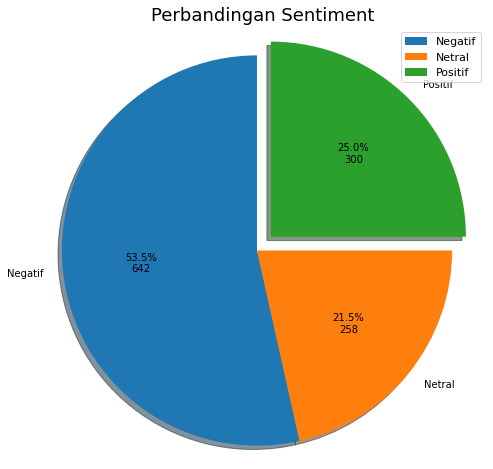

In [34]:
# Plotting Pie
def pct_pie(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n{:d}".format(pct, absolute)

sentimen = data['Content'].groupby(data['prediction']).count().values

plt.figure(figsize = (8,8))
plt.pie(sentimen, explode=(0,0,0.1), labels=['Negatif','Netral','Positif'], shadow=True,
        autopct=lambda pct: pct_pie(pct, sentimen),startangle=90)
plt.title('Perbandingan Sentiment',fontsize=18)
plt.axis('equal')
plt.legend(fontsize=11)
plt.show()

**Insight**

Dapat dilihat dari pie chart di atas bahwa pada rentang 19 - 27 April 2020 jumlah tweet masyarakat DKI Jakarta dengan topik COVID-19 yang bermuatan positif jauh lebih banyak dari tweet yang bermuatan negatif sedangkan tweet yang bermuatan netral jauh melampaui keduanya.

## 5.2. Tweet perhari Berdasarkan Sentimen

Akan dilihat perbandingan tweet perharinya dari tanggal 19 - 27 April 2020 berdasarkan sentimennya

In [35]:
# Melihat banyak Tweet perhari berdasarkan sentiment
data['Date'] = pd.to_datetime(data['Date'])
tph = data['Content'].groupby([data['Date'].dt.date, data['prediction']]).count()
frek = tph.values

# To Data Frame
tanggal = [ i for i, j in tph.index.tolist() ]
senti = [ j for i, j in tph.index.tolist() ]
sent = pd.DataFrame({'Date':tanggal,'Sentiment':senti, 'Frekuensi':frek})

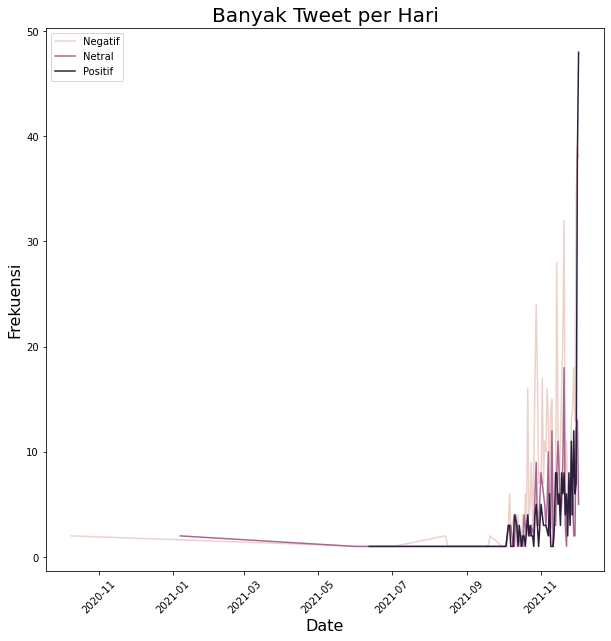

In [36]:
# Plotting line
plt.figure(figsize = (10,10))
sns.lineplot(x='Date',y='Frekuensi',hue='Sentiment',data=sent)
plt.title('Banyak Tweet per Hari',fontsize=20)
plt.xticks(rotation=45)
plt.xlabel('Date',fontsize=16)
plt.ylabel('Frekuensi',fontsize=16)
plt.legend(['Negatif','Netral','Positif'])
plt.show()

**Insight**

Dapat dilihat dari diagram garis di atas bahwa pada rentang 19 - 27 April 2020 jumlah tweet masyarakat DKI Jakarta dengan topik COVID-19 yang bermuatan netral jauh lebih banyak dan di susul oleh tweet yang bermuatan positif lalu tweet yang bermuatan netagtif. Dapat dilihat juga bahwa pada tanggal 25 April 2020 tweet yang bermuatan negatif jauh lebih banyak dari tweet yang bermuatan positif.

## 6. Penutup

Telah dilakukan Analisis Sentimen dan juga pemodelan terhadapa data hasil crawling. Data dipreprocess dan dilakukan vectorization menggunakan TF-IDF lalu dilakukan pemodelan. Dari berbagai model yang di uji didapatkan `SVM` adalah model dengan performa terbaik.

**Hal yang Dapat Dikembangkan**

1. Memperbanyak jumlah data yang dilakukan labeling secara manual
2. Melakukan hyperparameter tuning untuk mendapatkan hasil yang lebih maksimal
3. Menggunakan Boosting dalam pemodelan seperti, XGBoost, CatBoost, LGBM, dst.
4. Menggunakan metode Deep Learning

In [38]:
####################
## Saving Objects ##
####################

# if not os.path.isdir('output'):
#     os.mkdir('output')

if not os.path.isdir('model'):
    os.mkdir('model')

# Export data baru
data.to_csv('../output/Hasil Sentimen.csv', index=False)

# Saving Model
for name, model in classifiers.items():
    pickle.dump(model, open(f"../model/[TRAINED] {name}_{datetime.today().strftime('%Y-%m-%d')}.pickle", "wb"))
    
# Saving Vectorizer
# pickle.dump(vectorizer_tfidf, open("../model/vectorizer/vectorizer_tfidf.pickle", "wb"))
# pickle.dump(word_tfidf, open("../model/vectorizer/word_tfidf.pickle", "wb"))